In [11]:
#import libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy import ndimage, misc
import cv2
from skimage.morphology import skeletonize
from fil_finder import FilFinder2D
import astropy.units as u
import gc
import sklearn.metrics
import timeit
from scipy.interpolate import CubicSpline
gc.collect()
import sys

np.set_printoptions(threshold=False)

C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Hexagon\502.20\WAY3


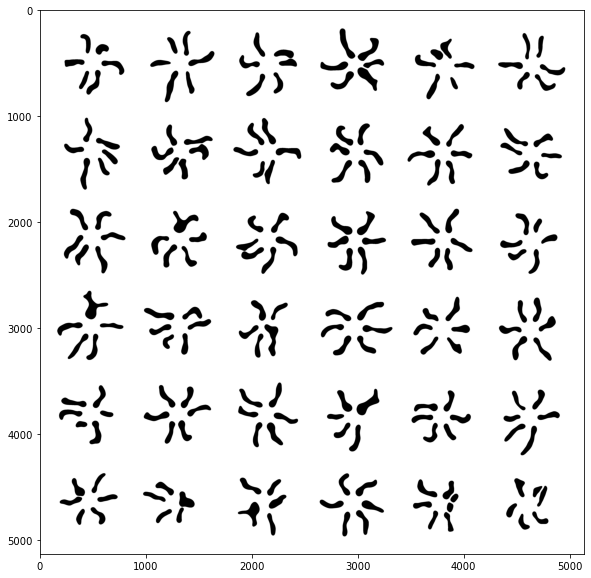

In [151]:
#insert path where images are located
%cd C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Hexagon\502.20\WAY3
#import images    
img =cv2.imread('WAY3_processed.tif',1) #segmented and eroded image (normally from DAPI stain)
img_gene1=cv2.imread('WAY3_CDX2.tif',0) #image of CDX2 gene expression
img_gene2=cv2.imread('WAY3_SOX1.tif',0) #image of SOX1 gene expression
img_gene3=cv2.imread('WAY3_CDX2.tif',0)
plt.figure(figsize=(10,10))

im_gene1=np.float32(img_gene1)
im_gene2=np.float32(img_gene2)

plt.imshow(img)

In [23]:
%cd C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_round1\combined
expNums = [1,2,3,4,5,6]
gene1_f_Names = []
gene2_f_Names = []
mask_f_Names=[]
for num in expNums:
    mask_f_Names.append('round1_0' + str(num) + '_segmentation.tif')
    gene1_f_Names.append('round1_0' + str(num) + '_CDX2.tif')
    gene2_f_Names.append('round1_0' + str(num) + '_SOX1.tif')
intensities_gene1 = []
intensities_gene2 = []
intensities_mask = []
for f in gene1_f_Names:
    img_gene1 = cv2.imread(f, 0)
    intensities_gene1.append(img_gene1.flatten())
for f in gene2_f_Names:
    img_gene2 = cv2.imread(f, 0)
    intensities_gene2.append(img_gene2.flatten())
for f in mask_f_Names:
    img = cv2.imread(f)
    intensities_mask.append(img[:,:,1].flatten())

C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_round1\combined


In [22]:
gene1_f_Names

['round1_01_CDX2.tif',
 'round1_02_CDX2.tif',
 'round1_03_CDX2.tif',
 'round1_04_CDX2.tif',
 'round1_05_CDX2.tif',
 'round1_06_CDX2.tif']

2852047
3395475
3409394
2106140
3286643
2544566
34.0


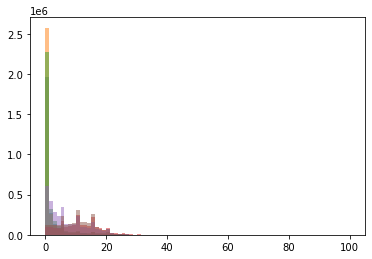

In [35]:
d=[]
for ii in range(np.shape(intensities_mask)[0]):
    a=np.where(intensities_mask[ii]==0)
    print(np.size(a))
    b=intensities_gene1[ii]
    c=b[a]
    d=np.append(d,c)
    plt.hist(c,80,alpha=0.5,range=(0,100))
cut1=np.quantile(d,0.999)
print(cut1)

10.0


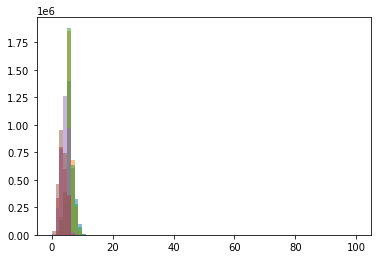

In [34]:
d=[]
for ii in range(np.shape(intensities_mask)[0]):
    a=np.where(intensities_mask[ii]==0)
    b=intensities_gene2[ii]
    c=b[a]
    d=np.append(d,c)
    plt.hist(c,80,alpha=0.5,range=(0,100))
cut2=np.quantile(d,0.999)
print(cut2)

In [74]:
obj=np.where(img[:,:,1]==0)

int_1=img_gene1[obj]
int_2=img_gene2[obj]
cut1=np.quantile(int_1,0.99)
cut2=np.quantile(int_2,0.99)

In [152]:
cut2=11#np.quantile(img_gene2,0.99) 10 11
cut1=28#np.quantile(img_gene1,0.99) 34 28
img_gene1=np.where(img_gene1<cut1,img_gene1, cut1)
img_gene2=np.where(img_gene2<cut2,img_gene2, cut2)

img_gene1=(img_gene1-np.min(img_gene1))/(cut1-np.min(img_gene1))
img_gene2=(img_gene2-np.min(img_gene2))/(cut2-np.min(img_gene2))
#cut2=np.quantile(img_gene2,0.99)
#cut2

(0.0, 1000000.0)

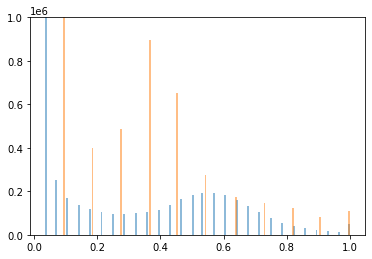

In [153]:
flat=np.ndarray.flatten(img_gene1)
flat = flat.astype('float')
flat[flat==0]=np.nan
plt.hist(flat,160,alpha=0.5)
flat=np.ndarray.flatten(img_gene2)
flat = flat.astype('float')
flat[flat==0]=np.nan
plt.hist(flat,160,alpha=0.5)

plt.ylim(0, 1*10**6)

In [147]:
img_2=np.array(img)
img_2[img==0]=255
img_2[img==255]=0
img=img_2

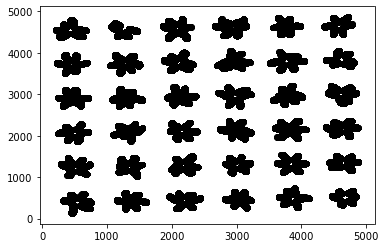

In [148]:
flat=np.ndarray.flatten(img)
obj=np.argwhere(img==255)
plt.plot(obj[:,0],obj[:,1],'k.')

In [52]:
np.quantile(img_gene2,0.99)

10.0

In [43]:
def get_intersection(hey,initial_pos,epsilon,contour): #function that finds the intersection points and also returns sides of region(normal line)
    # hey contains the points of the skeleton
    x_vec=hey[:,0]
    y_vec=hey[:,1]
    # find line across points of the skeleton centered on initial_pos and +- epsilon
    fit=np.polyfit(x=x_vec[initial_pos-epsilon:initial_pos+epsilon], y=y_vec[initial_pos-epsilon:initial_pos+epsilon], deg=1)
    # find contants of normal line
    m_normal=-1/fit[0]
    b_normal=y_vec[initial_pos]-(m_normal*x_vec[initial_pos])
    
    # if line is too steep, draw straight line and fill in betweens
    if abs(m_normal)>1000:
        y_list=np.linspace(y_vec[initial_pos]-500,y_vec[initial_pos]+500,1500000)
        x_list=np.repeat(x_vec[initial_pos], np.shape(y_list)[0])
        y_list = [int(x) for x in y_list]
        x_list=[int(x) for x in x_list]
    else:
        x_list=np.linspace(x_vec[initial_pos]-500,x_vec[initial_pos]+500,1500000)
        y_list=m_normal*x_list+b_normal
        y_list = [int(x) for x in y_list]
        x_list=[int(x) for x in x_list]
    
    coord_list=list(zip(y_list, x_list))
    arr2_3=np.array(coord_list)
    arr1=contour
    #print(arr2_3)
    
    indexes = np.unique(arr2_3, return_index=True,axis=0)[1]
    arr2_2=np.squeeze([arr2_3[index] for index in sorted(indexes)])
    arr2_4= np.squeeze([arr2_3[index] for index in sorted(indexes)])
    #print(arr2_2)
    # if points are diagonal, fill in so that points are always 1 away in any direction (makes sure there will be an intersection with contour)
    '''
    for hh in range(np.shape(arr2_2)[0]-1):
        if arr2_2[hh+1,0]==arr2_2[hh,0]+1 and arr2_2[hh+1,1]==arr2_2[hh,1]+1:
            temp=np.append(arr2_2[0:hh+1,:],[arr2_2[hh,:]+[1,0]],axis=0)
            arr2_4=np.append(temp,arr2_2[hh+1:],axis=0)
        if arr2_2[hh+1,0]==arr2_2[hh,0]-1 and arr2_2[hh+1,1]==arr2_2[hh,1]+1:
            temp=np.append(arr2_2[0:hh+1,:],[arr2_2[hh,:]-[1,0]],axis=0)
            arr2_4=np.append(temp,arr2_2[hh+1:],axis=0)
        if arr2_2[hh+1,0]==arr2_2[hh,0]+1 and arr2_2[hh+1,1]==arr2_2[hh,1]-1:
            temp=np.append(arr2_2[0:hh+1,:],[arr2_2[hh,:]+[1,0]],axis=0)
            arr2_4=np.append(temp,arr2_2[hh+1:],axis=0)
        if arr2_2[hh+1,0]==arr2_2[hh,0]-1 and arr2_2[hh+1,1]==arr2_2[hh,1]-1:
            temp=np.append(arr2_2[0:hh+1,:],[arr2_2[hh,:]-[1,0]],axis=0)
            arr2_4=np.append(temp,arr2_2[hh+1:],axis=0)
            
    for hh in range(np.shape(arr1)[0]-1):
        if arr1[hh+1,0]==arr1[hh,0]+1 and arr1[hh+1,1]==arr1[hh,1]+1:
            temp=np.append(arr1[0:hh+1,:],[arr1[hh,:]+[1,0]],axis=0)
            arr1=np.append(temp,arr1[hh+1:],axis=0)
        if arr1[hh+1,0]==arr1[hh,0]-1 and arr1[hh+1,1]==arr1[hh,1]+1:
            temp=np.append(arr1[0:hh+1,:],[arr1[hh,:]-[1,0]],axis=0)
            arr1=np.append(temp,arr1[hh+1:],axis=0)
        if arr1[hh+1,0]==arr1[hh,0]+1 and arr1[hh+1,1]==arr1[hh,1]-1:
            temp=np.append(arr1[0:hh+1,:],[arr1[hh,:]+[1,0]],axis=0)
            arr1=np.append(temp,arr1[hh+1:],axis=0)
        if arr1[hh+1,0]==arr1[hh,0]-1 and arr1[hh+1,1]==arr1[hh,1]-1:
            temp=np.append(arr1[0:hh+1,:],[arr1[hh,:]-[1,0]],axis=0)
            arr1=np.append(temp,arr1[hh+1:],axis=0) 
            '''
          
    
    
    #plt.scatter(arr1[:,0],arr1[:,1])
    #plt.scatter(arr2_2[:,0],arr2_2[:,1])
    #plt.xlim([13900, 13920])
    #plt.ylim([6360, 6380])
    #plt.show()
    arr2_2= np.array(arr2_4)
    intersection=np.array([x for x in set(tuple(x) for x in arr2_2) & set(tuple(x) for x in arr1)])
    #print(intersection)
    #if less than 2 points are found, run again with contour expanded by one (very rare case)
    
    #find better way
    if np.shape(intersection)[0]<2:
        arr1=np.concatenate((arr1,arr1+1),axis=0)
      
        intersection=np.array([x for x in set(tuple(x) for x in arr2_2) & set(tuple(x) for x in arr1)])
        #print(intersection)
    #if more than 2 intersection points, eliminate duplicates (two points super close to each other) and select closest points to skeleton 
    if np.shape(intersection)[0]>2: #fix this make more general
        dist_1=sklearn.metrics.pairwise_distances(intersection)
        
        np.fill_diagonal(dist_1, 100)
        dist_1=np.tril(dist_1, k=0)
        dist_1[dist_1==0]=100
        a=np.where(dist_1<5)
        mid_point=np.delete(intersection, a[0][:],0)
        intersection=mid_point
        #print(mid_point)
        if np.shape(mid_point)[0]>2:
            repe=np.repeat([[y_vec[initial_pos],x_vec[initial_pos]]],np.shape(mid_point)[0], axis=0)
            dist=np.sqrt((mid_point[:,0]-repe[:,0])**2+(mid_point[:,1]-repe[:,1])**2)
            
            mins=np.partition(dist,2)[0:2]
            min_id1=np.where(dist==mins[0])
            min_id2=np.where(dist==mins[1])
            
            
            intersection=mid_point[[min_id1[0][0],min_id2[0][-1]],:]
    #print(intersection)   
    id1=np.where((arr2_2[:,1]==intersection[0,1]) & (arr2_2[:,0]==intersection[0,0]))
    id2=np.where((arr2_2[:,1]==intersection[1,1]) & (arr2_2[:,0]==intersection[1,0]))
    id_min=np.min([id1[0][0],id2[0][0]])
    id_max=np.max([id1[0][0],id2[0][0]])
    side=coord_list[id_min:id_max]
    
    edge1=np.where((arr1[:,1]==intersection[0,1]) & (arr1[:,0]==intersection[0,0]))
    edge2=np.where((arr1[:,1]==intersection[1,1]) & (arr1[:,0]==intersection[1,0]))
    #print(side)
    return side, edge1, edge2, arr1

In [44]:
def get_gene_dipole(hey,contour,epsilon,img_gene1,img_gene2): #function that separates organoids into sections and returns gene dipole
    jj=0
    
    #n_segments=20 #number of segments
    #epsilon=np.shape(hey)[0]//n_segments
    
    epsilon=epsilon
    n_segments=np.shape(hey)[0]//epsilon
    initial_pos=epsilon
    gene1=np.empty([1,0])
    gene2=np.empty([1,0])
    position=np.empty([1,0])
    
    arr1=np.squeeze(contour)
    hh=-1
    
    for nn in range(np.shape(arr1)[0]-1):
            hh=hh+1
            #print(arr1[hh,:])
            if arr1[hh+1,0]==arr1[hh,0]+1 and arr1[hh+1,1]==arr1[hh,1]+1:
                temp=np.append(arr1[0:hh+1,:],[arr1[hh,:]+[1,0]],axis=0)
                arr1=np.vstack([temp,arr1[hh+1:]])
                hh=hh+1
            if arr1[hh+1,0]==arr1[hh,0]-1 and arr1[hh+1,1]==arr1[hh,1]+1:
                temp=np.append(arr1[0:hh+1,:],[arr1[hh,:]-[1,0]],axis=0)
                arr1=np.vstack([temp,arr1[hh+1:]])
                hh=hh+1
            if arr1[hh+1,0]==arr1[hh,0]+1 and arr1[hh+1,1]==arr1[hh,1]-1:
                temp=np.append(arr1[0:hh+1,:],[arr1[hh,:]+[1,0]],axis=0)
                arr1=np.vstack([temp,arr1[hh+1:]])
                hh=hh+1
            if arr1[hh+1,0]==arr1[hh,0]-1 and arr1[hh+1,1]==arr1[hh,1]-1:
                temp=np.append(arr1[0:hh+1,:],[arr1[hh,:]-[1,0]],axis=0)
                arr1=np.vstack([temp,arr1[hh+1:]])  
                hh=hh+1
    # if organoid only has two section aka small skeleton
    if initial_pos+epsilon>(np.shape(hey)[0]):
        mid_point=np.shape(hey)[0]//2
        eps=mid_point-1
        side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps, arr1)
        edges=np.sort([edge1[0][0],edge2[0][0]])
        
        #first half
        if edges[0]==edges[1]:
            edges[1]=edges[1]+1
        
        line1=arr1[edges[0]:edges[1]]
    
        if np.sum(line1[0,:]-line1[-1,:]) <0:
            line1=np.flip(line1,0)
        region_cont=np.concatenate((line1,side1))
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

        region = np.argwhere(filled_array == 255)
        #plt.plot(region[:,0],region[:,1],'bo')
        filled_array[filled_array==0]=np.nan
        segment=np.squeeze(img_gene1[:,:])*filled_array
        #segment[segment == 0] = np.nan
        gene1=np.append(gene1, np.nanmean(segment)/255)
        segment=np.squeeze(img_gene2[:,:])*filled_array
        #segment[segment == 0] = np.nan
        gene2=np.append(gene2, np.nanmean(segment)/255)
        position=np.append(position, mid_point-eps/2)
        
         
    
        # second half
        if edges[0]==edges[1]:
            edges[1]=edges[1]+1
        
        line1=np.concatenate((arr1[edges[1]:-1],arr1[0:edges[0]]))
    
        if np.sum(line1[0,:]-line1[-1,:]) <0:
            line1=np.flip(line1,0)
        region_cont=np.concatenate((line1,side1))
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

        region = np.argwhere(filled_array == 255)
        
        region = np.argwhere(filled_array == 255)
        #plt.plot(region[:,0],region[:,1],'ro')
        #plt.show()
        segment=np.squeeze(img_gene1[:,:])*filled_array
        segment[segment == 0] = np.nan
        gene1=np.append(gene1, np.nanmean(segment)/255)
        segment=np.squeeze(img_gene2[:,:])*filled_array
        segment[segment == 0] = np.nan
        gene2=np.append(gene2, np.nanmean(segment)/255)
        position=np.append(position, mid_point+eps/2)
       
         
        if np.shape(gene1)[0]==1:
            area_red=gene1[0]
            area_blue=gene2[0]
        else:
            area_red = np.trapz(gene1/np.max(gene1), dx=position[1]-position[0])
            area_blue = np.trapz(gene2/np.max(gene1), dx=position[1]-position[0])
        
        dipole=area_red/(area_red+area_blue)
    
    
    #long skeleton organoid
    n=0
    while (initial_pos+epsilon)<(np.shape(hey)[0]): #iterate through every point on skeleton to get normal lines
        #first section (fix path,sometimes wrong, take shortest path?)
        if n==0:
            mid_point=initial_pos
            eps=epsilon
            side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,arr1)
            edges=np.sort([edge1[0][0],edge2[0][0]])
            
            if edges[0]==edges[1]:
                edges[1]=edges[1]+1
        
            #line1=arr1[edges[0]:edges[1]]
            path1=np.concatenate((arr1[edges[1]:-1],arr1[0:edges[0]]))
            path2=arr1[edges[0]:edges[1]]
            if np.shape(path1)[0]>np.shape(path2)[0]:
                line1=path2
            else:
                line1=path1
            
            if np.sum(line1[0,:]-line1[-1,:]) <0:
                line1=np.flip(line1,0)
            region_cont=np.concatenate((line1,side1))
            im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
            filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

            region = np.argwhere(filled_array == 255)
            #plt.plot(region[:,0],region[:,1],'go')
            
            segment=np.squeeze(img_gene1[:,:])*filled_array
            segment[segment == 0] = np.nan
            gene1=np.append(gene1, np.nanmean(segment)/255)
            segment=np.squeeze(img_gene2[:,:])*filled_array
            segment[segment == 0] = np.nan
            gene2=np.append(gene2, np.nanmean(segment)/255)
            position=np.append(position, mid_point-eps/2)  
            
        
        n=n+1
        side1, edge1, edge2, arr1 = get_intersection(hey,initial_pos,epsilon,arr1)
       
        #edge_min_1=np.min([edge1,edge2])
        #edge_max_2=np.max([edge1,edge2])
    
        
        
        
        initial_pos=initial_pos+epsilon
        
        
        side2, edge3, edge4, arr1_1 = get_intersection(hey,initial_pos,epsilon,arr1)
        #temp fix
        if np.size(arr1_1)>np.size(arr1):
            arr1=arr1_1
        
       
        #edge_min_3=np.min([edge3,edge4])
        #edge_max_4=np.max([edge3,edge4])
        edges=np.sort([edge1[0][0],edge2[0][0],edge3[0][0],edge4[0][0]])
        if edges[0]==edges[1]:
            edges[1]=edges[1]+1
        if edges[2]==edges[3]:
            edges[3]=edges[3]+1
        path1=np.concatenate((arr1[edges[1]:-1],arr1[0:edges[0]]))
        path2=arr1[edges[0]:edges[1]]
        if np.shape(path2)[0]>np.shape(path1)[0]:
            line1=path1
        else:
            line1=path2
        path1=np.concatenate((arr1[edges[3]:-1],arr1[0:edges[2]]))
        path2=arr1[edges[2]:edges[3]]
        
        if np.shape(path2)[0]>np.shape(path1)[0]:
            line2=path1
        else:
            line2=path2
            
            
        #line1=arr1[edges[0]:edges[1]]
        #line2=arr1[edges[2]:edges[3]]
        
        if np.sum(line1[0,:]-line1[-1,:]) <0:
            line1=np.flip(line1,0)
        
        if np.sum(line2[0,:]-line2[-1,:]) >0:
            
            line2=np.flip(line2,0)
        side2=np.flip(side2,0)
        region_cont=np.concatenate((line1,side1,line2,side2))
        side_cross=np.array([x for x in set(tuple(x) for x in side1) & set(tuple(x) for x in side2)])
        if np.shape(side_cross)[0]>0:
            line1=np.flip(line1,0)
            line2=np.flip(line2,0)
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

        region = np.argwhere(filled_array == 255)
        segment=np.squeeze(img_gene1[:,:])*filled_array
        segment[segment == 0] = np.nan
        #plt.imshow(segment)
        gene1=np.append(gene1, np.nanmean(segment)/255)
        segment=np.squeeze(img_gene2[:,:])*filled_array
        segment[segment == 0] = np.nan
        gene2=np.append(gene2, np.nanmean(segment)/255)
        position=np.append(position, initial_pos-epsilon/2)
        initial_pos=initial_pos
        #plt.imshow(segment)
        #plt.axis([3800,4200,1300,1700])
        #plt.pause(0.05)
        
        #last section
        if n==n_segments-1:
            mid_point=initial_pos-epsilon//4
            eps=epsilon//4
            side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,arr1)
            edges=np.sort([edge1[0][0],edge2[0][0]])
            
            if edges[0]==edges[1]:
                edges[1]=edges[1]+1
        
            path1=np.concatenate((arr1[edges[1]:-1],arr1[0:edges[0]]))
            path2=arr1[edges[0]:edges[1]]
            if np.shape(path2)[0]>np.shape(path1)[0]:
                line1=path1
            else:
                line1=path2
    
            if np.sum(line1[0,:]-line1[-1,:]) <0:
                line1=np.flip(line1,0)
            
            region_cont=np.concatenate((line1,side1))
            im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
            filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))
            filled_array[filled_array == 0] = np.nan
            region = np.argwhere(filled_array == 255)
            img_gene1=np.float32(img_gene1)
            filled_array=np.float32(filled_array)
            segment=np.squeeze(img_gene1[:,:])*filled_array
            
            gene1=np.append(gene1, np.nanmean(segment)/255)
            
            img_gene2=np.float32(img_gene2)
            segment=np.squeeze(img_gene2[:,:])*filled_array
            
            gene2=np.append(gene2, np.nanmean(segment)/255)
            position=np.append(position, mid_point-eps/2)
             
    
    #gene_1_mean=np.mean(np.squeeze(img_gene1[:,:,0]))/np.max(gene1)
    #gene_2_mean=np.mean(np.squeeze(img_gene2[:,:,0]))/np.max(gene2)
    
   # print(dip_1)
    #print(dip_2)
    
    if np.shape(gene1)[0]==1:
        dip_1=0
        dip_2=0    
        dipole=np.abs(np.sum(dip_1)-np.sum(dip_2))/(np.shape(hey)[0]/2)
    else:
        #area_red = np.trapz(gene1/np.max(gene1), dx=position[1]-position[0])
        #area_blue = np.trapz(gene2/np.max(gene1), dx=position[1]-position[0])
        dip_1=gene1*(position-np.shape(hey)[0]/2)#/np.max(np.squeeze(img_gene1[:,:,0]))
        dip_2=gene2*(position-np.shape(hey)[0]/2)#/np.max(np.squeeze(img_gene2[:,:,0])) 
        #dip_2=0
        dipole=np.abs(np.sum(dip_1)-np.sum(dip_2))/(np.shape(hey)[0]/2)
        
        #if np.max(gene1/np.max(np.squeeze(img_gene1[:,:,0])))<0.03 or np.max(gene2)/np.max(np.squeeze(img_gene2[:,:,0]))<0.03:
         #   dipole=np.array([0])
        #print(gene1/np.max(np.squeeze(img_gene1[:,:,0])))
        #print(gene2/np.max(np.squeeze(img_gene2[:,:,0])))
        #print(position)
        #dipole=np.abs(np.sum(dip_1))/(np.shape(hey)[0]/2)
    #yp=np.linspace(0, 1, 1000)
    #plt.plot(position, gene1/np.max(gene1),'r.')
    #plt.plot(position, gene2/np.max(gene2),'b.')
    #plt.plot(yp,fit_1(yp),'r--')
    #plt.plot(yp,fit_2(yp),'b--')
    #plt.axis([0, position[-1]+50, 0, 1])
    #plt.show()
    if dipole.size == 0:
        dipole=0
    return dipole

In [ ]:

# Grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find Canny edges
edged = cv2.Canny(img, 30, 200)

#Find contours
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

#Initialize arrays
start = timeit.timeit()
dipole_list=np.empty([1,0])
elongation_list=np.empty([1,0])
aspect_ratio_list=np.empty([1,0])
meso_list=np.empty([1,0])
centroid_list=[[1,1], [1,1]]
true_org=np.empty([1,0])
mean_m_list=np.empty([1,0])
skel_list=np.empty([1,0])

#Check if contours are organoids
for ii in range(np.shape(contours)[0]):
    
    M = cv2.moments(contours[ii])
    if M["m00"] == 0:
        true_org=np.append(true_org,0)
    else:
        true_org=np.append(true_org,1)
    

for ii in range(np.shape(contours)[0]):
    
    if true_org[ii]==1:
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[contours[ii]], color=(255))
        
        # diff of mean intensity 
        filled_array[filled_array == 0] = np.nan
        segment=np.squeeze(img_gene1[:,:])*filled_array
        mean1=np.nanmean(segment)/(255*np.max(np.squeeze(img_gene1[:,:])))
        
        segment=np.squeeze(img_gene2[:,:])*filled_array
        mean2=np.nanmean(segment)/(255*np.max(np.squeeze(img_gene2[:,:])))
        
        meanm=mean1-mean2
        
        obj = np.argwhere(filled_array == 255)
        
        # average mesoderm intensity
        meso=np.nanmean(filled_array*np.squeeze(img_gene1[:,:]))/255
        

        bin_arr = np.where(filled_array > 0, 1, 0)
    
        image = bin_arr

    # perform skeletonization
    
        skeleton1 = skeletonize(image)


        binSkel = skeleton1*1
        skelObj = np.argwhere(binSkel == 1)

        fil = FilFinder2D(binSkel, distance=250 * u.pc, mask=skeleton1)
        fil.preprocess_image(flatten_percent=85)
        fil.create_mask(border_masking=True, verbose=False,
        use_existing_mask=True)
        fil.medskel(verbose=False)
        fil.analyze_skeletons(branch_thresh=40* u.pix, skel_thresh=5 * u.pix, prune_criteria='length')
        skeleton_length=fil.lengths()
        # how many tails the organoid has
        numb=fil.branch_properties['number']
        #print(skeleton_length)
        

        # find aspect ratio
        x,y,w,h = cv2.boundingRect(contours[ii])
        aspect_ratio = float(w)/h
        # find centroid
        M = cv2.moments(contours[ii])
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroid=np.array([cY,cX])
        
        # order skeleton
        hey_1 = np.argwhere(fil.skeleton_longpath==1)
        #print(np.size(hey_1))
        if hey_1.size==0:
            hey_1=skelObj
        im_zer = np.zeros( (img.shape[0],img.shape[1]) )
        skele_im=im_zer
        skele_im[hey_1[:,0],hey_1[:,1]]=255
        n=0
        ma=np.array([1,1,1])
        ok2=0
        while ok2==0:
            
            in_x=hey_1[n,0]
            in_y=hey_1[n,1]
            ma=skele_im[in_x-1:in_x+2,in_y-1:in_y+2]
            n=n+1
            if np.sum(ma)<255*3:
                ok2=1
        skeleton=np.array([[0,1],[in_x, in_y]])
        ok=0
        x_prev=1
        y_prev=1
        neighbors=skele_im[in_x-1:in_x+2,in_y-1:in_y+2]
        center_y=in_y
        center_x=in_x
        n=0
        while ok==0:
        
        
            neighbors[x_prev,y_prev]=0
            neighbors[1,1]=0
            res=np.where(neighbors==255)
            if res[0].size==0 :
         
                break
        
            y_next=res[1]
            x_next=res[0]
            skeleton=np.append(skeleton, [[x_next[0]-1+center_x, y_next[0]-1+center_y]], axis=0)
            y_prev=2-y_next[0]
            x_prev=2-x_next[0]
        
            center_y=center_y+y_next[0]-1
            center_x=center_x+x_next[0]-1
        
            neighbors=skele_im[-1+center_x:2+center_x,-1+center_y:2+center_y]
        

        skeleton=np.delete(skeleton, 0,0)
        hey=skeleton
        
        epsilon=20
        # If skeleton is small, extend a bit
        if np.shape(hey)[0]<6:
            hey=np.concatenate(([[hey[0,0]-1,hey[0,1]-1]],hey,[[hey[-1,0]+1,hey[-1,1]+1]]))
            hey=np.concatenate(([[hey[0,0]-1,hey[0,1]-1]],hey,[[hey[-1,0]+1,hey[-1,1]+1]]))
            
        # Elongation is equal to skeleton length
        elongation=np.shape(hey)[0]
       # print(elongation)
        # Get dipole
        dipole=get_gene_dipole(hey,contours[ii],epsilon,img_gene1,img_gene2)
        
        
        
    
        # Append values to lists
        dipole_list=np.append(dipole_list,dipole)
        elongation_list=np.append(elongation_list,elongation)
        if not skeleton_length.value:
            
            skel_list=np.append(skel_list,9)
        else:
            skel_list=np.append(skel_list,skeleton_length[0].value)
        aspect_ratio_list=np.append(aspect_ratio_list,aspect_ratio)
        meso_list=np.append(meso_list,meso)
        centroid_list=np.append(centroid_list,[centroid],axis=0)
        mean_m_list=np.append(mean_m_list,meanm)
        print('dipole gene=',dipole)
        print('elongation=',elongation)
        print('skel=',skeleton_length)
        print('aspect ratio=',aspect_ratio)
        print('centroid=',centroid)
        print('CDX2 marker=',meso)
        print('mean=',meanm)
#plt.show()
centroid_list=np.delete(centroid_list, [0,1],0)
end = timeit.timeit()
print(end - start)


C:\Users\heito\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\l

dipole gene= 0.2850846364123869
elongation= 144
skel= [161.22539674] pix
aspect ratio= 0.7218543046357616
centroid= [4838 4554]
CDX2 marker= 0.5673432078498676
mean= 0.17093066244280658


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.42138363190330613
elongation= 167
skel= [180.91168825] pix
aspect ratio= 0.38028169014084506
centroid= [4850 2184]
CDX2 marker= 0.4678660029641085
mean= 0.044515447340210346


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.4391328995403333
elongation= 154
skel= [172.46803743] pix
aspect ratio= 0.4919786096256685
centroid= [4828 3855]
CDX2 marker= 0.4194973202735168
mean= -0.04466826834226595


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.5689257239594657
elongation= 189
skel= [202.49747468] pix
aspect ratio= 0.3247863247863248
centroid= [4842 2882]
CDX2 marker= 0.3957102740389272
mean= -0.12249883359595748


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.2991444486072948
elongation= 132
skel= [155.02438662] pix
aspect ratio= 1.275
centroid= [4800 4714]
CDX2 marker= 0.5067303517151542
mean= 0.12441239215390137


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.2162810658512944
elongation= 142
skel= [164.19595949] pix
aspect ratio= 0.5393258426966292
centroid= [4807 3706]
CDX2 marker= 0.4672883744937665
mean= 0.04610741537506424


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.77809529278556
elongation= 188
skel= [216.40916293] pix
aspect ratio= 0.5148936170212766
centroid= [4822 3050]
CDX2 marker= 0.42043632374040013
mean= -0.12365255219082566


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.38806752278903095
elongation= 124
skel= [155.30865787] pix
aspect ratio= 1.126865671641791
centroid= [4766 1161]
CDX2 marker= 0.5119093318709441
mean= 0.09585628702711252


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.00792701170650406
elongation= 116
skel= [132.81118318] pix
aspect ratio= 0.5460526315789473
centroid= [4777  378]
CDX2 marker= 0.5361270166346233
mean= 0.07027776933423485


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.16523239856060165
elongation= 100
skel= [110.18376618] pix
aspect ratio= 0.48299319727891155
centroid= [4767 1318]
CDX2 marker= 0.577266087038477
mean= 0.10793647223632402


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.5699745970700425
elongation= 139
skel= [168.23759005] pix
aspect ratio= 0.8545454545454545
centroid= [4767  556]
CDX2 marker= 0.546903544026306
mean= 0.00631220867793747


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.026225216118216595
elongation= 95
skel= [116.36753237] pix
aspect ratio= 0.762962962962963
centroid= [4717 4441]
CDX2 marker= 0.633503516692178
mean= 0.22710671262820964


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.012182222502412365
elongation= 55
skel= [58.14213562] pix
aspect ratio= 0.6595744680851063
centroid= [4688 3865]
CDX2 marker= 0.24995951679243447
mean= -0.5414503881971577


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-44-4724cb0976cc>:

dipole gene= 0.6301668890657027
elongation= 254
skel= [267.08326112] pix
aspect ratio= 0.8803418803418803
centroid= [4739 2001]
CDX2 marker= 0.3000113422141567
mean= -0.3917001659021039


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.7246684503378038
elongation= 121
skel= [130.76955262] pix
aspect ratio= 2.5942028985507246
centroid= [4666 3607]
CDX2 marker= 0.5118000770480545
mean= -0.046988654445566325


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.2766055663616873
elongation= 155
skel= [180.92388155] pix
aspect ratio= 1.8034188034188035
centroid= [4680 3123]
CDX2 marker= 0.32525144791834604
mean= -0.3979963087524506


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.9227933406491786
elongation= 174
skel= [199.09545443] pix
aspect ratio= 2.746987951807229
centroid= [4662 2752]
CDX2 marker= 0.44633099141295873
mean= -0.1501707793352426


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-44-4724cb0976cc>:

dipole gene= 0.4887662918906021
elongation= 177
skel= [197.12489168] pix
aspect ratio= 2.4941176470588236
centroid= [4633  294]
CDX2 marker= 0.43691120921130483
mean= -0.03458617945715736


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.8332645898239706
elongation= 131
skel= [163.55129855] pix
aspect ratio= 1.2651515151515151
centroid= [4637 2235]
CDX2 marker= 0.421166884738908
mean= -0.28430582739491966


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.5682940350911666
elongation= 146
skel= [156.18376618] pix
aspect ratio= 2.6301369863013697
centroid= [4601  635]
CDX2 marker= 0.5008343073978078
mean= 0.04874672937639851


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11623996049647964
elongation= 28
skel= [36.9411255] pix
aspect ratio= 0.9166666666666666
centroid= [4601 3907]
CDX2 marker= 0.7427016452648475
mean= 0.12817151247628766


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6737537659319603
elongation= 176
skel= [200.2670273] pix
aspect ratio= 2.21875
centroid= [4586 1077]
CDX2 marker= 0.5437473359782287
mean= 0.12915848209628294


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.09536191948215748
elongation= 134
skel= [147.49747468] pix
aspect ratio= 0.9607843137254902
centroid= [4629 1373]
CDX2 marker= 0.6711831209401496
mean= -0.08582044474095873


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.012461479049639316
elongation= 92
skel= [112.53910524] pix
aspect ratio= 0.8504672897196262
centroid= [4535 4683]
CDX2 marker= 0.5665624077106882
mean= 0.1923333666896907


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.31790895401436225
elongation= 175
skel= [202.16652224] pix
aspect ratio= 0.4873096446700508
centroid= [4581 4737]
CDX2 marker= 0.499088944640797
mean= 0.13517289658169024


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6891289238314952
elongation= 130
skel= [156.33809512] pix
aspect ratio= 1.3461538461538463
centroid= [4507 1178]
CDX2 marker= 0.536504898845853
mean= -0.04625557022888138


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6843213669135084
elongation= 118
skel= [136.88225099] pix
aspect ratio= 0.6214689265536724
centroid= [4534 3858]
CDX2 marker= 0.4441196366447619
mean= -0.24528015953895393


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.8596401632146637
elongation= 172
skel= [207.03657993] pix
aspect ratio= 1.2911392405063291
centroid= [4503 3069]
CDX2 marker= 0.44837783820214266
mean= -0.17965209509865449


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.2684573561218564
elongation= 201
skel= [228.99494937] pix
aspect ratio= 1.1176470588235294
centroid= [4525 3635]
CDX2 marker= 0.4795184025953256
mean= -0.09259243874628503


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.816975311655128
elongation= 122
skel= [154.13708499] pix
aspect ratio= 0.8471337579617835
centroid= [4500 2201]
CDX2 marker= 0.5308439653293545
mean= -0.0461156318156668


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.386272992138924
elongation= 138
skel= [160.19595949] pix
aspect ratio= 0.5611111111111111
centroid= [4494 4524]
CDX2 marker= 0.46315047510606855
mean= 0.0911900510534156


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.8607648977875234
elongation= 114
skel= [136.19595949] pix
aspect ratio= 0.7309941520467836
centroid= [4512  357]
CDX2 marker= 0.48071903735728355
mean= -0.2942270883805594


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.0468211122655637
elongation= 171
skel= [205.62236636] pix
aspect ratio= 1.2893081761006289
centroid= [4493 1977]
CDX2 marker= 0.510354885162676
mean= 0.005959314903446256


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.8708197547043108
elongation= 172
skel= [214.07821049] pix
aspect ratio= 0.5165876777251185
centroid= [4472 2869]
CDX2 marker= 0.4071236041586443
mean= -0.12880713177209185


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.762974352087683
elongation= 163
skel= [198.45079349] pix
aspect ratio= 0.708994708994709
centroid= [4457  544]
CDX2 marker= 0.4573486256055845
mean= 0.02537850504910194


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.8182893238830465
elongation= 245
skel= [289.1492783] pix
aspect ratio= 0.5555555555555556
centroid= [4063 4621]
CDX2 marker= 0.43783157025318464
mean= -0.05758961963098047


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6438389498654776
elongation= 213
skel= [236.02438662] pix
aspect ratio= 0.43700787401574803
centroid= [4047 2982]
CDX2 marker= 0.5445080471212876
mean= 0.05567547048383298


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6314098484658336
elongation= 169
skel= [217.70562748] pix
aspect ratio= 1.1823529411764706
centroid= [3976 4474]
CDX2 marker= 0.48833975330616963
mean= 0.008007372749901098


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.36187379334118214
elongation= 111
skel= [137.33809512] pix
aspect ratio= 0.7547169811320755
centroid= [3982 3859]
CDX2 marker= 0.5311593708417207
mean= 0.1003019550308778


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.2676764876466857
elongation= 199
skel= [221.61017306] pix
aspect ratio= 0.7526881720430108
centroid= [4002 3698]
CDX2 marker= 0.5058677288280582
mean= 0.08277641146278886


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.4418488803358466
elongation= 131
skel= [159.82337649] pix
aspect ratio= 1.0748299319727892
centroid= [3974 2851]
CDX2 marker= 0.5428135608771447
mean= 0.06651882157662514


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.01841778311855
elongation= 167
skel= [202.86500705] pix
aspect ratio= 0.7096774193548387
centroid= [3995 2205]
CDX2 marker= 0.40658957049417865
mean= -0.2661724437097407


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.474632314027518
elongation= 191
skel= [212.78174593] pix
aspect ratio= 0.379746835443038
centroid= [4001 2045]
CDX2 marker= 0.41646749521988513
mean= -0.04936772118894539


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.5167848216231463
elongation= 164
skel= [184.12489168] pix
aspect ratio= 0.4719626168224299
centroid= [3982 1227]
CDX2 marker= 0.49892759651631347
mean= 0.005751982321591187


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.041780379572851606
elongation= 66
skel= [70.79898987] pix
aspect ratio= 1.85
centroid= [3906  389]
CDX2 marker= 0.6788907399694571
mean= 0.28685964181591006


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6313312386274063
elongation= 211
skel= [233.61017306] pix
aspect ratio= 0.5112107623318386
centroid= [3993  531]
CDX2 marker= 0.5533334038591741
mean= 0.050566546900966514


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.38539893693415517
elongation= 160
skel= [178.05382387] pix
aspect ratio= 0.6616161616161617
centroid= [3972 1359]
CDX2 marker= 0.4819162710401382
mean= -0.11227684702004909


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-44-4724cb0976cc>:

dipole gene= 0.4379734606678406
elongation= 160
skel= [173.49747468] pix
aspect ratio= 2.607594936708861
centroid= [3846 3600]
CDX2 marker= 0.5509627908353562
mean= 0.023742808165725826


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.22715037020387666
elongation= 118
skel= [128.18376618] pix
aspect ratio= 2.3333333333333335
centroid= [3849 4447]
CDX2 marker= 0.43298697754210846
mean= 0.08044132450518898


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6963675414193604
elongation= 156
skel= [176.53910524] pix
aspect ratio= 2.1868131868131866
centroid= [3852 3969]
CDX2 marker= 0.590032553700532
mean= 0.05560989756102763


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-44-4724cb0976cc>:

dipole gene= 0.2868876394803355
elongation= 126
skel= [130.38477631] pix
aspect ratio= 2.9454545454545453
centroid= [3833 2784]
CDX2 marker= 0.6780592834148584
mean= 0.20981228312220407


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.1207295583595545
elongation= 187
skel= [213.75230868] pix
aspect ratio= 2.149532710280374
centroid= [3850 2311]
CDX2 marker= 0.41857965552931187
mean= -0.1388148355452833


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.118961996493557
elongation= 195
skel= [216.36753237] pix
aspect ratio= 2.641304347826087
centroid= [3832 1099]
CDX2 marker= 0.4449441687344914
mean= -0.13808369050304536


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6191316257846851
elongation= 163
skel= [177.74011537] pix
aspect ratio= 2.5542168674698793
centroid= [3825 4800]
CDX2 marker= 0.5370067891941028
mean= 0.07800536111333467


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-44-4724cb0976cc>:

dipole gene= 0.01000950468328672
elongation= 83
skel= [89.87005769] pix
aspect ratio= 2.015873015873016
centroid= [3808  628]
CDX2 marker= 0.7278194109632115
mean= 0.27810954635972984


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.9138294474289864
elongation= 199
skel= [217.88225099] pix
aspect ratio= 2.2551020408163267
centroid= [3803  278]
CDX2 marker= 0.5859130489651694
mean= 0.03868368821990764


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.5482000517037009
elongation= 177
skel= [192.98275606] pix
aspect ratio= 1.7363636363636363
centroid= [3798 1955]
CDX2 marker= 0.5341553890035201
mean= 0.04752721259199627


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.794296234574229
elongation= 186
skel= [216.06601718] pix
aspect ratio= 2.0
centroid= [3769 1493]
CDX2 marker= 0.3658059632448799
mean= -0.11239672897017616


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6421048709230419
elongation= 181
skel= [196.56854249] pix
aspect ratio= 2.9220779220779223
centroid= [3743 3643]
CDX2 marker= 0.35042889390519194
mean= -0.18190026677611348


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.7166673898359053
elongation= 176
skel= [188.254834] pix
aspect ratio= 2.6263736263736264
centroid= [3702  316]
CDX2 marker= 0.43393074119076547
mean= -0.049855217686323505


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.4186994946069381
elongation= 160
skel= [190.48023074] pix
aspect ratio= 0.6989247311827957
centroid= [3682 4502]
CDX2 marker= 0.49417556957137354
mean= 0.12406826665418519


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.8000814337257548
elongation= 146
skel= [169.43860018] pix
aspect ratio= 0.5223880597014925
centroid= [3688 3860]
CDX2 marker= 0.41617554420102193
mean= -0.14436073480659456


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.0379468846038296
elongation= 150
skel= [180.06601718] pix
aspect ratio= 0.7024390243902439
centroid= [3695 2870]
CDX2 marker= 0.3988132347702172
mean= -0.23953407876412897


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.7980948404553042
elongation= 141
skel= [168.99494937] pix
aspect ratio= 0.6349206349206349
centroid= [3671 4705]
CDX2 marker= 0.45153355686252994
mean= -0.042170315256116975


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.0079300921369105
elongation= 234
skel= [271.93607486] pix
aspect ratio= 0.8605577689243028
centroid= [3713 3092]
CDX2 marker= 0.3658961884403976
mean= -0.21387009075262087


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.2402856740752044
elongation= 221
skel= [262.24978336] pix
aspect ratio= 1.23463687150838
centroid= [3672 1976]
CDX2 marker= 0.4516429590039184
mean= 0.0032669075744317655


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.7354305892187253
elongation= 142
skel= [167.50966799] pix
aspect ratio= 0.5980392156862745
centroid= [3653 1393]
CDX2 marker= 0.4153718374648608
mean= -0.14048277304091245


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.9788953859045169
elongation= 167
skel= [200.79393924] pix
aspect ratio= 0.5720930232558139
centroid= [3651  564]
CDX2 marker= 0.47198195892777156
mean= -0.0744903775132168


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.5404235908180415
elongation= 164
skel= [202.35028843] pix
aspect ratio= 0.7289719626168224
centroid= [3648 1190]
CDX2 marker= 0.4773225241016653
mean= 0.010695551339723108


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.8040709712674474
elongation= 186
skel= [213.99494937] pix
aspect ratio= 0.5211864406779662
centroid= [3637 2227]
CDX2 marker= 0.4353830693116409
mean= -0.07160236949197968


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.9662790978737181
elongation= 186
skel= [236.7766953] pix
aspect ratio= 0.7873303167420814
centroid= [3201 4737]
CDX2 marker= 0.4967523741265007
mean= 0.06443330455604229


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.187301968111344
elongation= 138
skel= [175.5218613] pix
aspect ratio= 0.9038461538461539
centroid= [3170 3914]
CDX2 marker= 0.45890004564125964
mean= 0.131530503575232


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.3753836331570453
elongation= 144
skel= [186.07821049] pix
aspect ratio= 0.9883040935672515
centroid= [3171 3670]
CDX2 marker= 0.6044801667604948
mean= 0.18742539279870185


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6498598095968678
elongation= 178
skel= [211.37972568] pix
aspect ratio= 0.6157205240174672
centroid= [3182 4512]
CDX2 marker= 0.493096060660445
mean= -0.05669122805586413


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.627943819204545
elongation= 171
skel= [201.06601718] pix
aspect ratio= 1.0647058823529412
centroid= [3167 3070]
CDX2 marker= 0.5246869039253086
mean= 0.06687530231539318


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.9251121496432588
elongation= 167
skel= [202.03657993] pix
aspect ratio= 0.925531914893617
centroid= [3172 2856]
CDX2 marker= 0.5148923312919084
mean= -0.040338657519166765


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.35124309312935476
elongation= 131
skel= [156.92388155] pix
aspect ratio= 0.7753623188405797
centroid= [3124 1202]
CDX2 marker= 0.5006232349790631
mean= 0.12848467142945663


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6674166476645481
elongation= 216
skel= [239.02438662] pix
aspect ratio= 0.4596774193548387
centroid= [3189  506]
CDX2 marker= 0.48357743790356783
mean= 0.06428887427320273


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.30257925593603896
elongation= 180
skel= [199.29646456] pix
aspect ratio= 0.36403508771929827
centroid= [3167 2059]
CDX2 marker= 0.5135403260403261
mean= 0.07834864084864102


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.5782753254173725
elongation= 208
skel= [269.13203436] pix
aspect ratio= 0.8099173553719008
centroid= [3168  362]
CDX2 marker= 0.458265297482976
mean= 0.030528442009264967


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.26946158881371496
elongation= 149
skel= [156.69848481] pix
aspect ratio= 0.33004926108374383
centroid= [3154 1366]
CDX2 marker= 0.5094439264590195
mean= 0.07478425612731154


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6417715277163204
elongation= 167
skel= [188.78174593] pix
aspect ratio= 2.675
centroid= [3013 4425]
CDX2 marker= 0.4854441067207025
mean= 0.01762549507230371


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.25671019720275295
elongation= 160
skel= [198.76450199] pix
aspect ratio= 1.4274809160305344
centroid= [3041 1965]
CDX2 marker= 0.4245597661732576
mean= -0.020722592509283322


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.8331399090212
elongation= 231
skel= [248.22539674] pix
aspect ratio= 3.4634146341463414
centroid= [3013 3175]
CDX2 marker= 0.41148994742423894
mean= -0.06885927214469306


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.5258228114662633
elongation= 117
skel= [123.87005769] pix
aspect ratio= 2.2564102564102564
centroid= [3008 3975]
CDX2 marker= 0.6056255095570252
mean= 0.11438783157235932


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.07803142847812305
elongation= 278
skel= [305.99494937] pix
aspect ratio= 0.4370860927152318
centroid= [3091 2189]
CDX2 marker= 0.6112351190476194
mean= 0.08972400537280001


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6117579325215335
elongation= 158
skel= [181.85281374] pix
aspect ratio= 2.0
centroid= [3014 1132]
CDX2 marker= 0.44133787067204155
mean= -0.056351625761173585


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6883116231190128
elongation= 191
skel= [219.82337649] pix
aspect ratio= 1.7380952380952381
centroid= [3008 2749]
CDX2 marker= 0.4204621655380975
mean= -0.03763096084771189


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.235068519886104
elongation= 157
skel= [184.5807358] pix
aspect ratio= 1.6486486486486487
centroid= [3003 3603]
CDX2 marker= 0.6078323809523809
mean= 0.19811601731601713


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-44-4724cb0976cc>:

dipole gene= 0.4971546065100588
elongation= 186
skel= [193.69848481] pix
aspect ratio= 3.8448275862068964
centroid= [2977  677]
CDX2 marker= 0.4747628399586175
mean= 0.11610321064721446


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-44-4724cb0976cc>:

dipole gene= 0.7393718561400132
elongation= 227
skel= [248.36753237] pix
aspect ratio= 1.9047619047619047
centroid= [2989  269]
CDX2 marker= 0.4446067984155688
mean= -0.020363884909544938


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.5141214904063883
elongation= 177
skel= [200.02438662] pix
aspect ratio= 2.207920792079208
centroid= [2962 1506]
CDX2 marker= 0.48641672714326806
mean= 0.08074590989380603


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.4288062033598989
elongation= 143
skel= [168.50966799] pix
aspect ratio= 1.1027397260273972
centroid= [2961 4793]
CDX2 marker= 0.5090002132594034
mean= 0.06438707308739028


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.7785500495912968
elongation= 197
skel= [230.37972568] pix
aspect ratio= 2.121739130434783
centroid= [2869 2811]
CDX2 marker= 0.4309399414944201
mean= -0.01976752075766164


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6038739309291903
elongation= 128
skel= [151.85281374] pix
aspect ratio= 1.208
centroid= [2877 3675]
CDX2 marker= 0.6065966339988287
mean= 0.09925680547979154


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-44-4724cb0976cc>:

dipole gene= 1.4343662515592295
elongation= 229
skel= [252.85281374] pix
aspect ratio= 2.4956521739130433
centroid= [2869 1127]
CDX2 marker= 0.43034109724108416
mean= -0.1404126704133214


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.5132707399783326
elongation= 169
skel= [208.59292911] pix
aspect ratio= 1.5537190082644627
centroid= [2858 1443]
CDX2 marker= 0.5314614763767308
mean= 0.05094312467193851


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.4043518593755835
elongation= 161
skel= [194.37972568] pix
aspect ratio= 0.9696969696969697
centroid= [2828 2248]
CDX2 marker= 0.5495792529895184
mean= 0.11215297505342298


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.1036820501080529
elongation= 223
skel= [267.1492783] pix
aspect ratio= 1.4431818181818181
centroid= [2826 3104]
CDX2 marker= 0.4499898799082446
mean= -0.09975803780620945


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.71253223276107
elongation= 158
skel= [185.99494937] pix
aspect ratio= 0.7371134020618557
centroid= [2826 2069]
CDX2 marker= 0.46855123264775506
mean= -0.13790576501821245


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.32044906822065766
elongation= 166
skel= [184.05382387] pix
aspect ratio= 0.4158878504672897
centroid= [2844 4539]
CDX2 marker= 0.49153819621487027
mean= 0.026676478046412766


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.9909300407867018
elongation= 178
skel= [199.78174593] pix
aspect ratio= 0.36363636363636365
centroid= [2824 4689]
CDX2 marker= 0.5326954039812645
mean= 0.008260480980767815


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.28543211465348617
elongation= 187
skel= [221.62236636] pix
aspect ratio= 0.5887445887445888
centroid= [2825 3903]
CDX2 marker= 0.5616334652109848
mean= 0.10043576580976077


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.2167704670878317
elongation= 270
skel= [298.82337649] pix
aspect ratio= 0.8740740740740741
centroid= [2794  494]
CDX2 marker= 0.41657195127880997
mean= -0.2045563673052606


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.3490365084834413
elongation= 218
skel= [243.50966799] pix
aspect ratio= 0.45726495726495725
centroid= [2377 4671]
CDX2 marker= 0.49336533032185215
mean= 0.07056020395941354


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.2659650178565665
elongation= 141
skel= [171.8944443] pix
aspect ratio= 1.6542056074766356
centroid= [2309 4495]
CDX2 marker= 0.5628674016055756
mean= 0.1295648099762997


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.3563134815492902
elongation= 159
skel= [175.39696962] pix
aspect ratio= 0.38571428571428573
centroid= [2353 3849]
CDX2 marker= 0.5476607267894655
mean= 0.12146923297768553


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.32684314106365514
elongation= 219
skel= [233.74011537] pix
aspect ratio= 0.6232558139534884
centroid= [2365 2902]
CDX2 marker= 0.45371988712938005
mean= -0.07791872779343334


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.3349298360623329
elongation= 143
skel= [167.2670273] pix
aspect ratio= 0.5957446808510638
centroid= [2338 3724]
CDX2 marker= 0.5421118076402378
mean= 0.06267591596701594


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.5415597151129767
elongation= 159
skel= [188.65180362] pix
aspect ratio= 1.8448275862068966
centroid= [2300 1998]
CDX2 marker= 0.5166167305848512
mean= 0.03386047677155024


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.48126160414170494
elongation= 208
skel= [246.35028843] pix
aspect ratio= 0.55078125
centroid= [2364 2163]
CDX2 marker= 0.4210570008702423
mean= -0.013792455540612203


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6500875985176032
elongation= 220
skel= [243.85281374] pix
aspect ratio= 0.33962264150943394
centroid= [2354 3046]
CDX2 marker= 0.4103689059989132
mean= -0.16377015393767047


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.4681215864753694
elongation= 181
skel= [208.99494937] pix
aspect ratio= 0.7448979591836735
centroid= [2339 1402]
CDX2 marker= 0.39077819918527895
mean= 0.03239793638023747


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.4818424094135534
elongation= 219
skel= [248.23759005] pix
aspect ratio= 0.44787644787644787
centroid= [2357  581]
CDX2 marker= 0.5147619047619048
mean= 0.08482618391709307


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1425111627723979
elongation= 160
skel= [193.79393924] pix
aspect ratio= 0.6582914572864321
centroid= [2302  391]
CDX2 marker= 0.5087436843896439
mean= 0.0653098962609685


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.33935292490467045
elongation= 161
skel= [191.8944443] pix
aspect ratio= 0.5954545454545455
centroid= [2315 1214]
CDX2 marker= 0.48858668236085406
mean= -0.005849014782090545


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.5038607886358466
elongation= 161
skel= [175.74011537] pix
aspect ratio= 2.776315789473684
centroid= [2208 4437]
CDX2 marker= 0.6400803640588691
mean= 0.15497368143088497


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-44-4724cb0976cc>:

dipole gene= 0.16253028505353206
elongation= 176
skel= [202.33809512] pix
aspect ratio= 1.8189655172413792
centroid= [2220 1949]
CDX2 marker= 0.5207452980189368
mean= 0.11091147396672302


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-44-4724cb0976cc>:

dipole gene= 0.5354566137312698
elongation= 171
skel= [175.38477631] pix
aspect ratio= 3.3823529411764706
centroid= [2184 3611]
CDX2 marker= 0.5662058178418611
mean= 0.056248454121597735


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.7149759873138054
elongation= 164
skel= [199.86500705] pix
aspect ratio= 1.544776119402985
centroid= [2216 3970]
CDX2 marker= 0.5207285216718267
mean= 0.04226841753447769


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-44-4724cb0976cc>:

dipole gene= 0.7767783419554419
elongation= 173
skel= [179.87005769] pix
aspect ratio= 3.338235294117647
centroid= [2178 3141]
CDX2 marker= 0.4404353655549396
mean= -0.1474833487061627


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.845488915697211
elongation= 218
skel= [249.30865787] pix
aspect ratio= 1.1063829787234043
centroid= [2210 2337]
CDX2 marker= 0.45346742167965864
mean= -0.11153545307465013


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-44-4724cb0976cc>:

dipole gene= 0.40680579411395196
elongation= 207
skel= [229.61017306] pix
aspect ratio= 0.9550561797752809
centroid= [2201 1111]
CDX2 marker= 0.5233692106979779
mean= 0.10307724999505846


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.8577441134382119
elongation= 147
skel= [170.43860018] pix
aspect ratio= 1.7391304347826086
centroid= [2190 2818]
CDX2 marker= 0.43510960258512593
mean= -0.24465222910108103


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.5290702409440904
elongation= 205
skel= [253.29141392] pix
aspect ratio= 0.8214285714285714
centroid= [2230  312]
CDX2 marker= 0.5063677684605621
mean= 0.0502138532740703


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.15252681174774663
elongation= 108
skel= [125.63961031] pix
aspect ratio= 1.7191011235955056
centroid= [2156 4807]
CDX2 marker= 0.5745752248267728
mean= 0.2113493124522537


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-44-4724cb0976cc>:

dipole gene= 0.04257103769122037
elongation= 136
skel= [144.9411255] pix
aspect ratio= 1.7872340425531914
centroid= [2151 1499]
CDX2 marker= 0.7094277929155314
mean= 0.2558038147138964


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.9542398704522815
elongation= 191
skel= [215.2670273] pix
aspect ratio= 3.038961038961039
centroid= [2135  687]
CDX2 marker= 0.5299001727778843
mean= 0.05264926089460514


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.28204818872084236
elongation= 92
skel= [106.32590181] pix
aspect ratio= 0.6119402985074627
centroid= [2030 4690]
CDX2 marker= 0.7145798251482094
mean= 0.241699887388569


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.6139708198215488
elongation= 182
skel= [215.37972568] pix
aspect ratio= 1.1420454545454546
centroid= [2044 2842]
CDX2 marker= 0.42806547838644043
mean= -0.2669232191847111


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.8145809269740015
elongation= 156
skel= [185.23759005] pix
aspect ratio= 0.9316770186335404
centroid= [2023 2023]
CDX2 marker= 0.49778090568680805
mean= -0.0225249246322225


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6179959819730704
elongation= 197
skel= [220.43860018] pix
aspect ratio= 0.6328502415458938
centroid= [2001 4564]
CDX2 marker= 0.5215451644575355
mean= 0.04285881644129064


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.4959712843621232
elongation= 159
skel= [194.03657993] pix
aspect ratio= 0.8947368421052632
centroid= [1996 2260]
CDX2 marker= 0.47508766207290204
mean= -0.016479728377306713


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6198325869792177
elongation= 171
skel= [225.0904038] pix
aspect ratio= 0.96
centroid= [2007 3672]
CDX2 marker= 0.5047169811320759
mean= 0.05377358490566064


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.5563271343752894
elongation= 188
skel= [230.07821049] pix
aspect ratio= 0.7522123893805309
centroid= [2017 3076]
CDX2 marker= 0.4605757015821689
mean= -0.21615931225874607


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6653644621209379
elongation= 187
skel= [210.02438662] pix
aspect ratio= 0.8715083798882681
centroid= [1968  580]
CDX2 marker= 0.6142065362411
mean= 0.0867005256243275


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.04437863605608476
elongation= 257
skel= [311.50461736] pix
aspect ratio= 1.1476190476190475
centroid= [2002 1350]
CDX2 marker= 0.44575270019601904
mean= -0.1849934759963307


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.24085984157013385
elongation= 180
skel= [214.62236636] pix
aspect ratio= 0.8431372549019608
centroid= [1961  373]
CDX2 marker= 0.5775002506656565
mean= 0.09995634872808667


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6393413915743952
elongation= 171
skel= [204.79393924] pix
aspect ratio= 0.5646551724137931
centroid= [1987 3877]
CDX2 marker= 0.41994549672304676
mean= -0.12048561559833809


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.5028533574623592
elongation= 167
skel= [185.05382387] pix
aspect ratio= 0.8203592814371258
centroid= [1525 4710]
CDX2 marker= 0.5399024670109007
mean= 0.009772857664423595


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.27257206320731386
elongation= 153
skel= [170.22539674] pix
aspect ratio= 0.732484076433121
centroid= [1515 2076]
CDX2 marker= 0.5234235614265893
mean= 0.11483152270966102


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.5033954393768189
elongation= 176
skel= [195.29646456] pix
aspect ratio= 0.3918918918918919
centroid= [1527 3875]
CDX2 marker= 0.4455916537910106
mean= -0.06990532122072601


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.7031452183380433
elongation= 158
skel= [183.50966799] pix
aspect ratio= 1.5703125
centroid= [1491 4524]
CDX2 marker= 0.5232301880003599
mean= -0.09060447962579798


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6890326916507479
elongation= 207
skel= [250.32085117] pix
aspect ratio= 0.9112149532710281
centroid= [1531 2854]
CDX2 marker= 0.4427000055135909
mean= -0.09165317507656379


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.530105226661149
elongation= 170
skel= [193.43860018] pix
aspect ratio= 0.5251141552511416
centroid= [1516 3068]
CDX2 marker= 0.5365451421548342
mean= -0.022468752387109103


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1038412121742563
elongation= 198
skel= [223.09545443] pix
aspect ratio= 0.42857142857142855
centroid= [1527 2162]
CDX2 marker= 0.49358248521340675
mean= 0.08996782311310514


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.4802356819806832
elongation= 215
skel= [246.30865787] pix
aspect ratio= 0.508
centroid= [1536 3726]
CDX2 marker= 0.4244701955287355
mean= -0.09238721946604872


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.2051550352311746
elongation= 138
skel= [148.18376618] pix
aspect ratio= 0.4619289340101523
centroid= [1497 1355]
CDX2 marker= 0.5337813779597652
mean= 0.04934290384708789


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.5832107193204822
elongation= 255
skel= [274.71067812] pix
aspect ratio= 0.30666666666666664
centroid= [1539  424]
CDX2 marker= 0.46952506730847676
mean= 0.0033239354876988814


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.4934492764463429
elongation= 143
skel= [169.75230868] pix
aspect ratio= 0.6666666666666666
centroid= [1483  595]
CDX2 marker= 0.6754113162118779
mean= 0.26261764920472774


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.567874871023455
elongation= 148
skel= [185.93607486] pix
aspect ratio= 0.9156626506024096
centroid= [1475 1233]
CDX2 marker= 0.5407410615049293
mean= 0.012279727951143515


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.4289164560595714
elongation= 156
skel= [162.87005769] pix
aspect ratio= 3.769230769230769
centroid= [1373 4824]
CDX2 marker= 0.6035157346912032
mean= 0.1865919429803587


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-44-4724cb0976cc>:

dipole gene= 0.9078172657497633
elongation= 155
skel= [165.18376618] pix
aspect ratio= 2.6493506493506493
centroid= [1358 3974]
CDX2 marker= 0.549042286406088
mean= -0.03693247329748506


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.369223691379614
elongation= 222
skel= [246.68124087] pix
aspect ratio= 2.3944954128440368
centroid= [1365 3602]
CDX2 marker= 0.41914651381909557
mean= -0.21480449120603012


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.7282491532403716
elongation= 168
skel= [200.13708499] pix
aspect ratio= 1.2384105960264902
centroid= [1379 3155]
CDX2 marker= 0.5064645841806279
mean= -0.007156334344322501


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1766490570849537
elongation= 109
skel= [145.27922061] pix
aspect ratio= 1.0638297872340425
centroid= [1383  663]
CDX2 marker= 0.5646049617390455
mean= 0.13038559302632996


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.0276041083484186
elongation= 219
skel= [240.78174593] pix
aspect ratio= 2.2735849056603774
centroid= [1336 2349]
CDX2 marker= 0.5584325748745756
mean= -0.04603064548080482


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.9372603863127853
elongation= 183
skel= [207.68124087] pix
aspect ratio= 2.659090909090909
centroid= [1337 1940]
CDX2 marker= 0.544605849187756
mean= 0.05820371284869397


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6228200789922905
elongation= 215
skel= [258.73506474] pix
aspect ratio= 1.5514705882352942
centroid= [1351 1143]
CDX2 marker= 0.5251866636331673
mean= -0.0018873192827151275


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6001894879306002
elongation= 193
skel= [216.85281374] pix
aspect ratio= 1.2384105960264902
centroid= [1330 1515]
CDX2 marker= 0.49882771296982875
mean= 0.000838093845624055


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.5772827068306496
elongation= 155
skel= [173.05382387] pix
aspect ratio= 2.076923076923077
centroid= [1311  316]
CDX2 marker= 0.6080344706188486
mean= 0.12829980477039288


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.0502632234729579
elongation= 131
skel= [160.23759005] pix
aspect ratio= 1.606837606837607
centroid= [1313 2825]
CDX2 marker= 0.48836486885487895
mean= -0.17568172870876986


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6955750186148
elongation= 170
skel= [200.06601718] pix
aspect ratio= 1.725
centroid= [1307 4439]
CDX2 marker= 0.5357699712026474
mean= 0.0680827414038237


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-44-4724cb0976cc>:

dipole gene= 0.6537899242839729
elongation= 175
skel= [198.02438662] pix
aspect ratio= 2.027027027027027
centroid= [1264  642]
CDX2 marker= 0.5847126580693626
mean= 0.07533491924377067


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6489877005360538
elongation= 233
skel= [253.53910524] pix
aspect ratio= 3.1627906976744184
centroid= [1231 1491]
CDX2 marker= 0.3738725755119199
mean= -0.05193658800216172


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.7446076957030765
elongation= 144
skel= [174.06601718] pix
aspect ratio= 1.4230769230769231
centroid= [1224 4744]
CDX2 marker= 0.45499711271672216
mean= -0.07153708462492825


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


In [93]:
ii

61

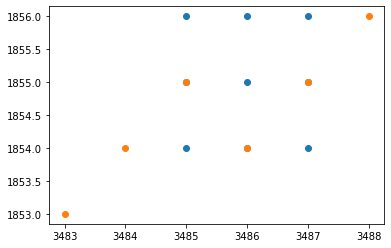

In [97]:
plt.scatter(obj[:,0],obj[:,1])
plt.scatter(hey[:,0],hey[:,1])
#plt.xlim([13900, 13920])
#plt.ylim([6360, 6380])

In [96]:
np.shape(obj)


(9, 2)

829
1143


(6360.0, 6380.0)

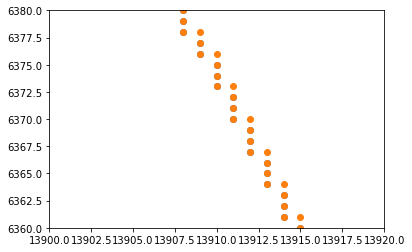

In [30]:
arr1=np.squeeze(contours[106])
plt.scatter(arr1[:,0],arr1[:,1])
arr1_mod= None
print(len(arr1))
hh=-1
for nn in range(np.shape(arr1)[0]-1):
        hh=hh+1
        #print(arr1[hh,:])
        if arr1[hh+1,0]==arr1[hh,0]+1 and arr1[hh+1,1]==arr1[hh,1]+1:
            temp=np.append(arr1[0:hh+1,:],[arr1[hh,:]+[1,0]],axis=0)
            arr1=np.vstack([temp,arr1[hh+1:]])
            hh=hh+1
        if arr1[hh+1,0]==arr1[hh,0]-1 and arr1[hh+1,1]==arr1[hh,1]+1:
            temp=np.append(arr1[0:hh+1,:],[arr1[hh,:]-[1,0]],axis=0)
            arr1=np.vstack([temp,arr1[hh+1:]])
            hh=hh+1
        if arr1[hh+1,0]==arr1[hh,0]+1 and arr1[hh+1,1]==arr1[hh,1]-1:
            temp=np.append(arr1[0:hh+1,:],[arr1[hh,:]+[1,0]],axis=0)
            arr1=np.vstack([temp,arr1[hh+1:]])
            hh=hh+1
        if arr1[hh+1,0]==arr1[hh,0]-1 and arr1[hh+1,1]==arr1[hh,1]-1:
            temp=np.append(arr1[0:hh+1,:],[arr1[hh,:]-[1,0]],axis=0)
            arr1=np.vstack([temp,arr1[hh+1:]])  
            hh=hh+1
#print(len(arr1_mod))
print(len(arr1))
plt.scatter(arr1[:,0],arr1[:,1])
plt.xlim([13900, 13920])
plt.ylim([6360, 6380])

In [29]:
nn

827

array([[2910,  672],
       [2913,  675],
       [2912,  674],
       [2911,  673]])

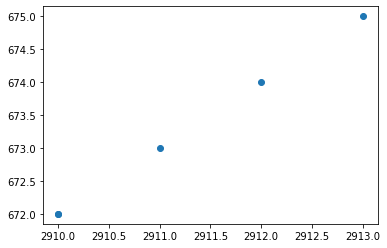

In [96]:
a=np.array([[2910,  672],[2913,  675],
 [2912,  674],
 [2911,  673],
 [2910,  672]])
plt.scatter(a[:,0],a[:,1])

indexes = np.unique(a, return_index=True,axis=0)[1]
np.squeeze([a[index] for index in sorted(indexes)])

C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\paired


(564.5, 12037.5, 535.5, 12514.5)

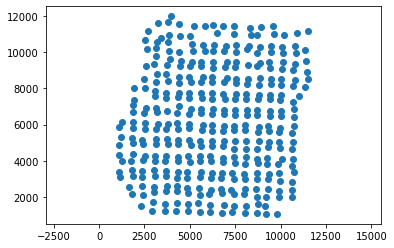

In [7]:
%cd C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\paired 
new_metric=pd.read_csv('exported_metrics_paired_n.csv', delimiter=',')
arr=new_metric.to_numpy()
plt.scatter(arr[:,3]*2,arr[:,4]*2)
plt.axis('equal')

In [ ]:
print('skel=',skeleton_length)
        print('aspect ratio=',aspect_ratio)
        print('centroid=',centroid)
        print('CDX2 marker=',meso)

In [150]:
# save data, there is probably a better way to do this, but I am not sure
d = {'Dipole': dipole_list, 'Elongation': elongation_list, 'Aspect_Ratio': aspect_ratio_list, 'Centroid_x':centroid_list[:,1] , 'Centroid_y': centroid_list[:,0], 'Diff_of_means': mean_m_list, 'CDX2 Marker': meso_list, 'Skeleton': skel_list}
df = pd.DataFrame(data=d)
# name of the table
df.to_csv('exported_metrics_SFRP1_n2.csv', index=False)
df

,Dipole,Elongation,Aspect_Ratio,Centroid_x,Centroid_y,Diff_of_means,CDX2 Marker,Skeleton
0,0.021554,59.0,0.632479,527,4802,0.109658,0.470528,62.556349
1,0.126489,104.0,0.515924,1360,4816,0.030101,0.480606,113.355339
2,0.545737,127.0,0.480663,2193,4794,-0.012623,0.480480,141.325902
3,0.376232,71.0,0.801653,400,4757,0.120322,0.541555,90.296465
4,0.129375,75.0,0.795276,638,4760,0.092558,0.493125,91.811183
...,...,...,...,...,...,...,...,...
210,0.626315,112.0,0.797546,4423,336,0.048323,0.540116,140.409163
211,0.517893,131.0,0.393617,2067,322,-0.016192,0.439552,140.769553
212,0.615266,133.0,0.414365,2911,320,-0.091596,0.464558,143.183766
213,0.368257,92.0,0.561728,3734,290,0.144959,0.607280,102.597980


# end of code bellow is just debugging / visualization stuff

C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_7


<ipython-input-13-350cc57ec73f>:31: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_bad(color = 'k', alpha = 1)


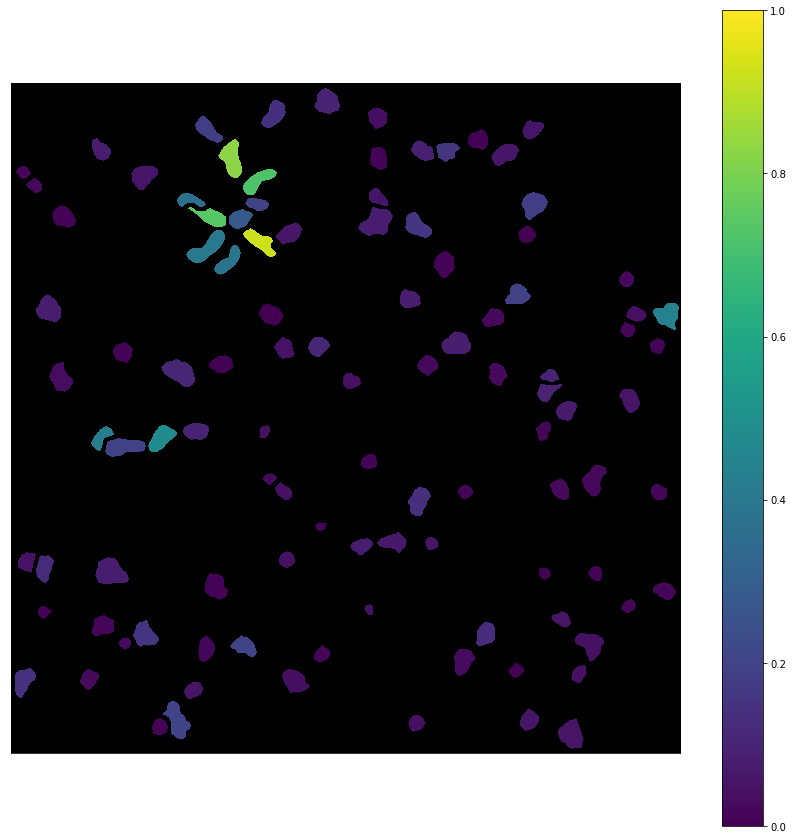

In [13]:
%cd C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_7
img =cv2.imread('final_random_7_masks.tif',1) #segmented and eroded image (normally from DAPI stain)


# visualize dipole moment
df= pd.read_csv('exported_metrics_random_7_n.csv')
dipole_list=pd.DataFrame.to_numpy(df)[:,0]
# Grayscale8
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find Canny edges
edged = cv2.Canny(img, 30, 200)

#Find contours
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

im_color=np.zeros( (img.shape[0],img.shape[1]) )

im_color[im_color==0]=np.nan
for ii in range(np.shape(dipole_list)[0]):
    
    
    im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image
    filled_array = cv2.fillPoly(im_zer, pts =[contours[ii]], color=(255))
        
    obj = np.argwhere(filled_array == 255)
    im_color[obj[:,0],obj[:,1]]=dipole_list[ii]
plt.figure(figsize=(15,15))

cmap = plt.cm.get_cmap("viridis")
cmap.set_bad(color = 'k', alpha = 1)
im = plt.imshow(im_color, cmap=cmap,vmin=0, vmax=1)
im_color_par=im_color
plt.colorbar(im)
plt.xticks([])
plt.yticks([])
plt.savefig("sample.pdf", dpi=300)


C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_12


<ipython-input-7-9da9c40a74f9>:18: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_bad(color = 'w', alpha = 1)


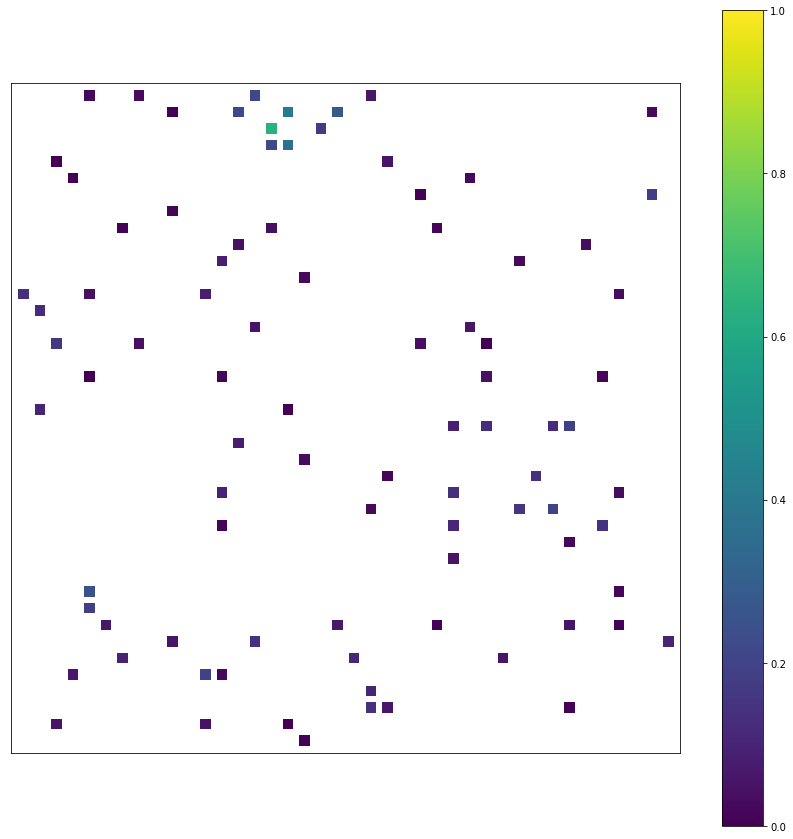

In [7]:
%cd C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_12
#img =cv2.imread('final_random_4_masks.tif',1) #segmented and eroded image (normally from DAPI stain)


# visualize dipole moment
df= pd.read_csv('random_features_dipole_v3.csv')
df=df.loc[df['seeds'] == 12]
dipole_list=pd.DataFrame.to_numpy(df)[:,-1]

x_list=pd.DataFrame.to_numpy(df)[:,-3]
y_list=pd.DataFrame.to_numpy(df)[:,-2]

im_color, o = centroids_to_image(150, x_list+50, y_list+50, 50, 100, 40, dipole_list )

plt.figure(figsize=(15,15))
im_color[im_color==0]=np.nan
cmap = plt.cm.get_cmap("viridis")
cmap.set_bad(color = 'w', alpha = 1)
im = plt.imshow(im_color, cmap=cmap,vmin=0, vmax=1)
im_color_par=im_color
plt.colorbar(im)
plt.xticks([])
plt.yticks([])
plt.savefig("sample.pdf", dpi=300)

In [4]:
def centroids_to_image(pattern_size, cx, cy, spacing, edge, pattern_dim, dipole):
    
    
    overlap = 0
    
    scale=pattern_size+spacing
    gc.collect()
    im = np.zeros((pattern_dim*scale+edge , pattern_dim*scale+edge))
    #print(scale)
    #print()
    gc.collect()
    im_overlap=np.zeros((pattern_dim*scale+edge , pattern_dim*scale+edge))
    for k in range(cx.shape[0]):
        x, y = int(cx[k]), int(cy[k])
        
        space=int(pattern_size/2)
        im[x-space:x+space,y-space:y+space] = dipole[k]
        
        space_2=int(scale/2)
        im_overlap[x-space_2:x+space_2,y-space_2:y+space_2] = im_overlap[x-space_2:x+space_2,y-space_2:y+space_2] + 1
    if np.max(im_overlap)>1:
        
        overlap = 1
    
    return im, overlap

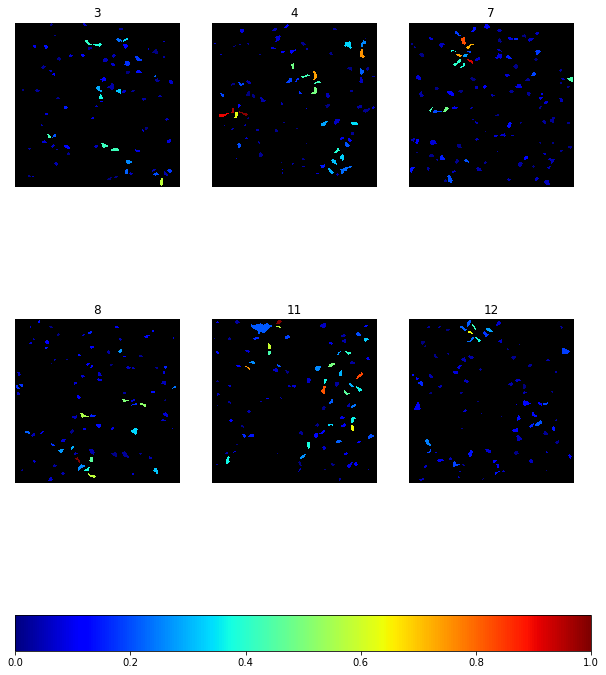

In [237]:

fig, axs = plt.subplots(2,3,figsize=(10,10))

axs[0,0].imshow(im_color_3, cmap = cmap,vmin=0, vmax=1)
axs[0,0].set_title("3")
axs[0,0].axis('off')
axs[0,1].imshow(im_color_4, cmap = cmap,vmin=0, vmax=1)
axs[0,1].set_title("4")
axs[0,1].axis('off')
im = axs[0,2].imshow(im_color_7, cmap = cmap,vmin=0, vmax=1)
axs[0,2].set_title("7")
axs[0,2].axis('off')
im = axs[1,0].imshow(im_color_8, cmap = cmap,vmin=0, vmax=1)
axs[1,0].set_title("8")
axs[1,0].axis('off')
im = axs[1,1].imshow(im_color_11, cmap = cmap,vmin=0, vmax=1)
axs[1,1].set_title("11")
axs[1,1].axis('off')
im = axs[1,2].imshow(im_color_12, cmap = cmap,vmin=0, vmax=1)
axs[1,2].set_title("12")
axs[1,2].axis('off')
p0 = axs[0,0].get_position().get_points().flatten()
p1 = axs[0,1].get_position().get_points().flatten()
p2 = axs[1,2].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], -0.05, 0.8, 0.05])
im= axs[1,2].imshow(im_color_12, cmap = cmap,vmin=0, vmax=1)
plt.colorbar(im, cax=ax_cbar, orientation='horizontal')


<ipython-input-9-6c82dc197039>:17: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmap.set_bad(color = 'k', alpha = 1)


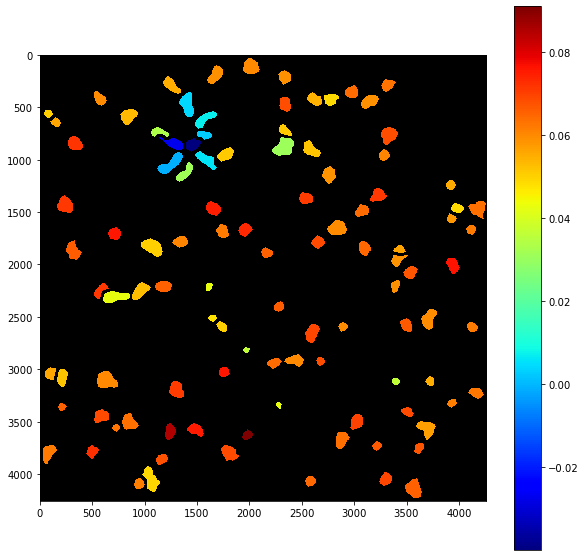

In [9]:
# visualize mean metric

im_color=np.zeros( (img.shape[0],img.shape[1]) )
 
im_color[im_color==0]=np.nan
for ii in range(np.shape(dipole_list)[0]):
    
    if true_org[ii]==1:
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image
        filled_array = cv2.fillPoly(im_zer, pts =[contours[ii]], color=(255))
        
        obj = np.argwhere(filled_array == 255)
        im_color[obj[:,0],obj[:,1]]=mean_m_list[ii]
plt.figure(figsize=(10,10))

cmap = plt.cm.get_cmap("jet")
cmap.set_bad(color = 'k', alpha = 1)
im = plt.imshow(im_color, cmap=cmap)

plt.colorbar(im)

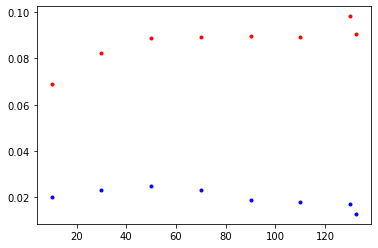

70.5

In [161]:
gene1=[0.06886484, 0.08211693, 0.08898413, 0.08910554, 0.08972873, 0.08920459,0.09819136, 0.09031054]
gene2=[0.02023379, 0.02307213, 0.02497011, 0.02308543, 0.0188759,  0.01797035, 0.01734052, 0.01285602]
pos=[ 10,   30,   50,   70,   90,  110,  130,  132.5]
plt.plot(pos,gene1,'r.')
plt.plot(pos,gene2,'b.')
plt.show()
np.shape(hey)[0]/2

In [ ]:
gene1=0
dip_1=gene1/np.max(gene1)*(position-np.shape(hey)[0]/2)
dip_2=gene2/np.max(gene2)*(position-np.shape(hey)[0]/2)    
dipole=np.abs(np.sum(dip_1)-np.sum(dip_2))/(np.shape(hey)[0]/2)

In [46]:
mean_m_list=np.empty([0,0])
[meanm]
mean_m_list=np.append(mean_m_list,meanm,axis=0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 0 dimension(s)

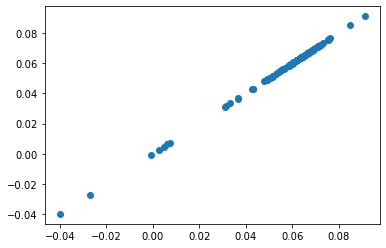

In [53]:
plt.scatter(mean_m_list,mean_m_list)
plt.show()

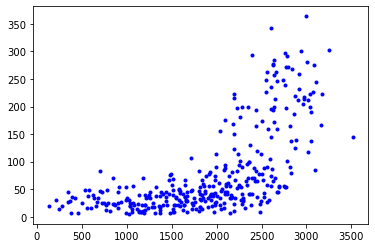

In [133]:
plt.plot(dist,elongation_list,'b.')

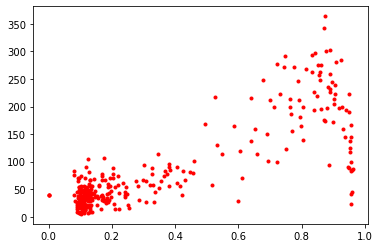

In [134]:
plt.plot(dipole_list,elongation_list,'r.')

(282.25, 6018.75, 267.75, 6257.25)

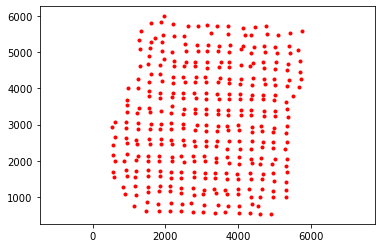

In [138]:
plt.plot(centroid_list[:,1],centroid_list[:,0],'r.')
plt.axis('equal')